### 0. Imports

In [1]:
import torch
import torch.nn as nn
import pickle
import numpy as np
from torch.utils.data import Dataset , DataLoader
import sys
import pyreadr
import copy
import random
from pathlib import Path
import pandas as pd
sys.path.append("../snpe/")
import torch.nn.functional as F
import seaborn as sns
import matplotlib as plt

#print(sys.path)
from snpe.simulations import simulator_class, marketplace_simulator_class

from snpe.utils.functions import nn_converged # Function to authomatically stop convergence

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### A. Load the data: using the real data

Load reviews real data

In [2]:
reviews = pyreadr.read_r("data/reviews_bazaarvoice_main_vars.Rds")
reviews = reviews[None] #extracting dataframe


Load embeddings data

In [3]:
embbeddings = pd.read_csv("data/productspace.tsv", sep = "\t", header=None)
minus_prod = lambda s : s.replace("product_", "")
embbeddings[0] = embbeddings[0].apply(func= minus_prod)
embbeddings = embbeddings.set_index(0, drop=False)


### B. Data pre-processing, Dataset and DataLoader

Assigning each "asin" to its corresponding embbedding in a dictionary for later use.

In [4]:
len(reviews["asin"].unique()) # reviews of 1406 real products
len(embbeddings[0].unique()) # embeddings for 31704 real products

coincidences = []
embd_dict = {}

for i in reviews["asin"].unique():
    if str(i) in embbeddings[0].unique():
        embd_dict[i] = np.array(embbeddings.loc[str(i)][1:])

#embd_dict

Separating data by product, storing it in different dictionaries for train, validation and test (30%, 20%, 50%), all of this while preserving the appropriate chronological order of the reviews.

In [5]:
frames_dict_train = {}
frames_dict_validation = {}
frames_dict_test = {}

for i in embd_dict.keys():
    frames_dict_train[i] = reviews[reviews["asin"]== i].sort_values(by = "ReviewId").iloc[:int(reviews[reviews["asin"]== i].shape[0]//3.3333)].reset_index()
    frames_dict_validation[i] = reviews[reviews["asin"]== i].sort_values(by = "ReviewId").iloc[int(reviews[reviews["asin"]== i].shape[0]//3.3333):reviews[reviews["asin"]== i].shape[0]//(2)].reset_index()
    frames_dict_test[i] = reviews[reviews["asin"]== i].sort_values(by = "ReviewId").iloc[reviews[reviews["asin"]== i].shape[0]//(2):].reset_index()
    
    
for i in embd_dict.keys():
    frames_dict_train[i]['emb'] = [embd_dict.get(i) for e in range(frames_dict_train[i].shape[0])]
    frames_dict_validation[i]['emb'] = [embd_dict.get(i) for e in range(frames_dict_validation[i].shape[0])]
    frames_dict_test[i]['emb'] = [embd_dict.get(i) for e in range(frames_dict_test[i].shape[0])]

Sample of how data is split for product "1017360"

Train (30%)

In [6]:
frames_dict_train.get(1017360)

,index,asin,overall,ReviewId,unixReviewTime,rootcategoryid,emb
0,104,1017360,4,9186319,2011-02-16,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
1,106,1017360,5,9312754,2011-03-02,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
2,105,1017360,5,9313265,2011-03-02,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
3,108,1017360,5,9316925,2011-03-03,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
4,107,1017360,5,9320306,2011-03-03,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
...,...,...,...,...,...,...,...
61,164,1017360,5,13467012,2012-02-05,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
62,165,1017360,5,13835766,2012-02-15,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
63,166,1017360,5,14860492,2012-03-07,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
64,167,1017360,1,14940874,2012-03-08,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."


Validation (20%)

In [7]:
frames_dict_validation.get(1017360)

,index,asin,overall,ReviewId,unixReviewTime,rootcategoryid,emb
0,171,1017360,5,16003890,2012-03-21,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
1,169,1017360,1,16004163,2012-03-21,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
2,170,1017360,4,16009516,2012-03-21,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
3,172,1017360,3,16133666,2012-03-28,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
4,173,1017360,5,16495266,2012-04-18,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
5,174,1017360,5,16601854,2012-04-26,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
6,175,1017360,5,17131022,2012-05-10,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
7,176,1017360,4,17710339,2012-05-23,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
8,177,1017360,1,19398032,2012-06-12,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
9,178,1017360,4,19723381,2012-06-19,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."


Test (50%)

In [8]:
frames_dict_test.get(1017360)

,index,asin,overall,ReviewId,unixReviewTime,rootcategoryid,emb
0,213,1017360,5,27280987,2013-05-31,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
1,214,1017360,1,27293847,2013-06-03,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
2,215,1017360,5,27397350,2013-06-06,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
3,216,1017360,5,27505296,2013-06-12,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
4,217,1017360,5,27754074,2013-06-26,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
...,...,...,...,...,...,...,...
106,309,1017360,5,46453667,2015-03-04,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
107,322,1017360,5,46640149,None,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
108,310,1017360,4,46646413,2015-03-10,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."
109,311,1017360,5,46827663,2015-03-17,33006169,"[0.0029107, 0.0199935, -0.0198807, 0.00917163,..."


Detecting and discarding products which do not have enough reviews to satisfy the "size" requirements of the sliding window format. In this case sliding window length/width is 10 reviews. (i.e. a review in t+1 is predicted on the basis of the reviews from t-9 to t0)

In [9]:
window_length = 10

list_bool_length = []
keys_to_discard = []


for k in frames_dict_validation.keys():
    list_bool_length.append(frames_dict_validation.get(k).shape[0] >= (window_length + 1))
    if frames_dict_validation.get(k).shape[0] < (window_length + 1):
        keys_to_discard.append(k)

for k in keys_to_discard:
    del frames_dict_train[k]
    del frames_dict_validation[k]
    del frames_dict_test[k]
    
# 699 out of 1404 products have enough reviews to build at least 1 validation sample
print(
    f'''{str(sum(list_bool_length))} out of {str(len(list_bool_length))} have enough reviews to be included in the
final data set given the specified window length of {window_length}. The remainder where discarded.
''' 
)

699 out of 1404 have enough reviews to be included in the
final data set given the specified window length of 10. The remainder where discarded.



Transformation of each row of each product the data frames created above into 1-D tensors containing each rating and embedding. This particular configuration of each tensor including rating+embedding in its lower dimension has been designed this way to make it easier to feed the data to the model while complying with the requirements of pytorch's dataset and dataloader classes that wrap the data so it can be provided to the model. These tensors are then stacked to form a tensor of (n, 101) dimensions where n is the corresponding number of reviews.

In [10]:
# Dictionaries to store each product's tensors
tens_train = {}
tens_validation = {}
tens_test = {}

# Tensors for each row are created and stores in a list for the train, validation and test sets
for p in frames_dict_train.keys():
    #print(p)
    a_product_list = []
    for i in range(frames_dict_train.get(p).shape[0]):
        temp_list = []
        temp_list.append(frames_dict_train.get(p)['overall'][i])
        for k in frames_dict_train.get(p)['emb'][i]:
            temp_list.append(k)
        a_product_list.append(torch.FloatTensor(temp_list))
    tens_train[p] = a_product_list
    #print(a_product_list)
    
for p in frames_dict_train.keys():
    #print(p)
    a_product_list = []
    for i in range(frames_dict_validation.get(p).shape[0]):
        temp_list = []
        temp_list.append(frames_dict_validation.get(p)['overall'][i])
        for k in frames_dict_validation.get(p)['emb'][i]:
            temp_list.append(k)
        a_product_list.append(torch.FloatTensor(temp_list))
    tens_validation[p] = a_product_list
    #print(a_product_list)
    
for p in frames_dict_train.keys():
    #print(p)
    a_product_list = []
    for i in range(frames_dict_test.get(p).shape[0]):
        temp_list = []
        temp_list.append(frames_dict_test.get(p)['overall'][i])
        for k in frames_dict_test.get(p)['emb'][i]:
            temp_list.append(k)
        a_product_list.append(torch.FloatTensor(temp_list))
    tens_test[p] = a_product_list
    #print(a_product_list)

# Stacking all tensors in all dictionaries to have a tensor of (n, 101) per product intead of a list of tensors    
for t in tens_train.keys():
    tens_train[t] = torch.stack([i for i in tens_train.get(t)])
    tens_validation[t] = torch.stack([i for i in tens_validation.get(t)])
    tens_test[t] = torch.stack([i for i in tens_test.get(t)])

Now we have 3 dictionaries containing the train, validation and test sets for each product. For each product, and set we have a tensor of shape (n_i, 101) as mentioned above. For example, if a given product has N ratings, in the dictionary containing the training sets the value associated to its product ID key we will have a tensor of the shape (N\*0.3, 101), in the validation dictionary a tensor with a shape of (N\*0.2, 101) and finally in the test dictionary a tensor of the shape (N\*0.5, 101). 

As you can see in the example below, the first element of the tensor is the corresponding rating for a given T, followed by the 100-d embedding of the product to which it belongs.

In [13]:
tens_train.get(1017360)[0]

tensor([ 4.0000e+00,  2.9107e-03,  1.9994e-02, -1.9881e-02,  9.1716e-03,
         1.9235e-02, -7.0281e-03, -5.3703e-03,  9.5135e-04, -2.2286e-02,
         1.3778e-02, -4.1408e-02, -1.5520e-02, -2.1755e-03,  2.2203e-02,
        -2.8938e-02, -1.2219e-02,  2.6656e-02, -1.3024e-02,  4.4244e-02,
        -4.0905e-03, -7.8043e-03,  3.3163e-02, -1.1404e-02,  1.7175e-03,
         1.5078e-02,  1.8824e-02, -9.7987e-03, -1.1135e-02, -1.2177e-02,
         3.0665e-02,  2.0524e-02, -1.3165e-02,  3.9614e-02,  1.6273e-03,
         7.5149e-03, -6.4778e-03,  1.4776e-02, -1.4481e-03,  1.7568e-02,
        -8.0347e-03,  1.2923e-03,  2.9955e-02,  2.9933e-02, -4.4433e-03,
        -8.8186e-03,  1.1811e-03,  5.1223e-02,  1.6176e-02,  2.6995e-02,
         4.1468e-03,  4.4859e-02, -2.3765e-02,  2.2506e-02,  2.1003e-02,
        -2.8345e-02, -1.5568e-02,  2.1291e-02, -2.0661e-02, -3.0756e-03,
        -4.4781e-03, -2.6516e-02, -4.5507e-03, -2.0287e-02,  2.4336e-02,
         2.0215e-02,  3.6595e-03,  4.6210e-03,  2.1

A bit of context on the cells below:
In pytorch you can either import pre existing datasets or use your own. To use your own you have to define it as aninstance of the dataset class, including three functions: `__init__, __len__` and `__getitem__` .

- Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

- More about this can be found in pytorch's documentation: 
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- Main source for the desgin of the `SlidingDataset` class: https://discuss.pytorch.org/t/dataloader-for-a-lstm-model-with-a-sliding-window/22235 . 

Defining an appropriate dataset class according to the needs of the model.

In [12]:
class SlidingDataset(Dataset):
    '''
    This SlidingDataset class is conformed so each input is comprised of the last N observations (from t-n to t) 
    of the series, where n  is the size of the sliding window, and the target is the corresponding observation in 
    t+1.
    '''
    def __init__(self, data, window):
        self.data = data
        #self.data = torch.from_numpy(data)
        self.window = window
        
    def __len__(self): 
        '''
        The __len__ function returns the number of samples in our dataset. In this case intuitively we have
        a number of samples equal to the total number of elements in the time series minus the size of the 
        sliding window. (i.e. How many previous observations conform each input)
        '''
        return len(self.data)-self.window

    def __getitem__(self, index): 
        
        ratings = torch.from_numpy(np.array([float(self.data[i][0]) for i in range(len(self.data))]))
        
        return  (ratings[index : index+self.window].double(), self.data[0][1:]) , ratings[index+self.window].double()

Now, with the sliding dataset class defined the data can be processed by it and then subsequently to the dataloader class. This is done for all products across the three previously defined dictionaries for training, validation and test.

In [14]:
datasets_list_train = []
datasets_list_validation = []
datasets_list_test = []
sliding_window_size = 10

for i in frames_dict_train.keys():
    a = SlidingDataset(torch.from_numpy(np.array(tens_train.get(i))), sliding_window_size)
    b = SlidingDataset(torch.from_numpy(np.array(tens_validation.get(i))), sliding_window_size)
    c = SlidingDataset(torch.from_numpy(np.array(tens_test.get(i))), sliding_window_size)
    datasets_list_train.append(a)
    datasets_list_validation.append(b)
    datasets_list_test.append(c)

final_train_set= torch.utils.data.ConcatDataset(datasets_list_train)
final_validation_set= torch.utils.data.ConcatDataset(datasets_list_validation)
final_test_set= torch.utils.data.ConcatDataset(datasets_list_test)

batch_size = 32

train_dataloader = DataLoader(final_train_set,batch_size, shuffle = True) 
validation_dataloader = DataLoader(final_validation_set,batch_size) #, shuffle = True)
test_dataloader = DataLoader(final_test_set,batch_size) #, shuffle = True)  

print("Cell execution completed")

Cell execution completed


Example of how the elements of the resulting dataloader objects are structured.

For each batch there are 32 feature-target pairs. The features are subdivided in two, ratings and embeddings. Each feature element contains: 

   - 1. 32 rating sliding window inputs and 
   - 2. Their correspondent 32 embeddings

Below there is an example how input-target pairs are configured by the dataloader class in this case. The input is composed of two "parts", an array of 10 ratings (corresponding to the last 10 ratings before the target rating occurred, going from T-9 to T0), and the 100-d embedding of the product. As mentioned above, the target is the rating at T+1.

In [15]:
'''
From the train dataloader, an sliding window input of 10, 
the corresponding embedding of the product and the target respectively
'''

for k,v in enumerate(train_dataloader):
    print('#####################')
    print(' -> Sliding window sample')
    print(v[0][0][0]) # First sliding window sample
    print('#####################')
    print(' -> Embbedding')
    print(v[0][1][0]) # Embbedding from the product to which the sliding window belongs
    print('#####################')
    print(' -> Target')
    print(v[1][0]) # Target (rating 'T+1' assuming that  the sliding window goes from 'T-9' to 'T')
    print('#####################')
    break

#####################
 -> Sliding window sample
tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], dtype=torch.float64)
#####################
 -> Embbedding
tensor([ 0.0176, -0.0038, -0.0071,  0.0003,  0.0019, -0.0145,  0.0096,  0.0048,
        -0.0047, -0.0014, -0.0003, -0.0237, -0.0081, -0.0096,  0.0094, -0.0008,
        -0.0124, -0.0025,  0.0033, -0.0073, -0.0016,  0.0079,  0.0120,  0.0083,
         0.0084,  0.0005,  0.0095,  0.0121,  0.0002,  0.0037,  0.0036,  0.0096,
         0.0033,  0.0048, -0.0022,  0.0027,  0.0059, -0.0004,  0.0020, -0.0035,
         0.0009,  0.0008, -0.0168, -0.0055, -0.0050,  0.0026, -0.0048, -0.0094,
        -0.0117,  0.0202,  0.0165,  0.0063,  0.0143, -0.0031, -0.0124, -0.0075,
        -0.0054, -0.0045,  0.0056, -0.0063,  0.0020, -0.0078,  0.0002, -0.0075,
         0.0235, -0.0045, -0.0015,  0.0067, -0.0121, -0.0065,  0.0117,  0.0005,
         0.0082,  0.0055,  0.0060,  0.0022, -0.0040, -0.0043,  0.0030,  0.0053,
         0.0074, -0.0013,  0.0064,  0.0052, -

### C. The model

The model is structured as a LSTM cell followed by a feedforward neural network with an input layer, three hidden layers and an output layer. The The LSTM cell receives as an input the last ten ratings, while the network takes as inputs the output of the LSTM plus the corresponding product embedding.

Some relevant parameters of the LSTM cell: (More detailed information can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html))
- __Input_dim__: The number of expected features in the input x 
- __Hidden_dim__: The number of features in the hidden state h 
- __Layer_dim__: Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1



In [17]:
class LSTM_1(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim):
        super(LSTM_1, self).__init__()
        
        self.input_dim = input_dim # n of expected features in the input
        self.hidden_dim = hidden_dim # Hidden dimensions - n of features in hidden state
        self.layer_dim = layer_dim  # Number of hidden layers 
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim) #LSTM
        self.OLA = nn.Linear(110,64)
        self.OLB = nn.Linear(64,32)
        self.OLC = nn.Linear(32,16)
        self.OLD = nn.Linear(16,8)
        self.OLE = nn.Linear(8,1)
        self.double()
        # Note: HLA = 'Hidden Layer A', OLB = 'Hidden Layer B', and so on...

    def forward(self, x):
        # Initialize hidden state & cell states with zeros 
        # theoretically not 100% necessary - made by default for zeros
        h0 = torch.zeros(size=(self.layer_dim, 10), device='cuda').requires_grad_()
        c0 = torch.zeros(size=(self.layer_dim, 10), device='cuda').requires_grad_()
       
        out, (hn, cn) = self.lstm(x[0].double(), (h0.double(),c0.double()))
        
        # OLA is fed with the combination of LSTM output and the corresponding embeddings.
        outA = F.relu(self.OLA(torch.cat((out,x[1]), dim=1))) 
        outB = F.relu(self.OLB(outA))
        outC = F.relu(self.OLC(outB))
        outD = F.relu(self.OLD(outC))
        outE = self.OLE(outD)
        
 
        return outE, hn, cn

### D. Training loop

Adapted from ebmd. to ratings training loop

In [20]:
count = 0

for batch, (x, y) in enumerate(train_dataloader):
    count += (len(x*1))
    
train_indices_A = count
count = 0    

for batch, (x, y) in enumerate(validation_dataloader):
    count += (len(x*1))
    

val_indices_A = count

In [21]:
input_dim = 10 
hidden_size = 10
num_layers = 1
learning_rate=1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTM_1(input_dim , hidden_size , num_layers).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [22]:
def nn_converged_B(epoch: int, stop_after_epochs: int, validation_loss: torch.Tensor, model: torch.nn.Module) -> bool:
    converged = False
    # (Re)-start the epoch count with the first epoch or any improvement.
    if epoch == 0 or validation_loss < model.best_validation_loss:
        model.best_validation_loss = validation_loss
        model.epochs_since_last_improvement = 0
        model.best_model = copy.deepcopy(model.state_dict())
    else:
        model.epochs_since_last_improvement += 1

    # If no validation improvement over many epochs, stop training.
    if model.epochs_since_last_improvement > stop_after_epochs - 1:
        model.load_state_dict(model.best_model)
        converged = True
    return converged

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def fit(
        train_loader: DataLoader,
        val_loader: DataLoader,
        train_indices: torch.Tensor,
        val_indices: torch.Tensor,
        num_epochs: int = 100,
        print_per_num_epochs: int = 5,
        convergence_num_epochs: int = 15,
    ) -> None:
# Run the training loop
    for epoch in range(num_epochs):
        print(f"epoch {epoch}")
        # Set the model in training mode for gradient evaluation
        model.train()
        # Set current loss value
        train_loss = 0.0
        # Iterate over the DataLoader for training data
        for batch, (inputs, targets) in enumerate(train_loader):
            if torch.cuda.is_available():
                inputs[0] = inputs[0].cuda() 
                inputs[1] = inputs[1].cuda()
                targets = targets.cuda()
            # Send inputs and targets to cuda
            #inputs.to(device)
            #targets.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            out, hn, cn = model(inputs)
            out = out.reshape(len(inputs[1]))[0] # ADDED + añadiste el 0 entre corchetes para intentart arreglar el tema del broadcasting
            # Compute loss
            loss = criterion(out, targets).mean()
            hn = hn.detach() # ADDED
            cn = cn.detach() # ADDED
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()
            # Add to the total of the training loss
            train_loss += loss.item() * len(inputs)
        # Once all training batches have been run, get the mean training loss
        #train_loss /= len(train_indices)
        train_loss /= train_indices
        # Set the model in evaluation mode so that gradients are not evaluated
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(val_loader):
                inputs[0] = inputs[0].cuda() 
                inputs[1] = inputs[1].cuda()
                targets = targets.cuda()
                preds, hn, cn = model(inputs)
                loss = criterion(preds, targets).mean()
                val_loss += loss.item() * len(inputs)
            #val_loss /= len(val_indices)
            val_loss /= val_indices
        if epoch % print_per_num_epochs == 0: 
            print(f"Train Loss after epoch: {epoch}: {train_loss}") 
            print(f"Validation loss after epoch: {epoch}: {val_loss}") 
        if nn_converged_B(epoch, convergence_num_epochs, val_loss, model): 
            print(f"Stopping after epoch {epoch} as validation loss was not improving further") 
            break 
    
    # Process is complete.
    print("Training process has finished.")
    # print(f"Best loss: {self.model.best_validation_loss}")

Training execution

In [24]:
fit(train_loader = train_dataloader, val_loader = validation_dataloader, train_indices = train_indices_A, val_indices = val_indices_A)

epoch 0


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Loss after epoch: 0: 13.711423828734315
Validation loss after epoch: 0: 1.2744138994517002
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
Train Loss after epoch: 5: 1.1675084397476425
Validation loss after epoch: 5: 1.1922985872795433
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
Train Loss after epoch: 10: 1.1505751694729636
Validation loss after epoch: 10: 1.1836869648710469
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Train Loss after epoch: 15: 1.1441559405759067
Validation loss after epoch: 15: 1.1810579017178864
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Train Loss after epoch: 20: 1.1412802478139523
Validation loss after epoch: 20: 1.1770800925413476
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Train Loss after epoch: 25: 1.1388987870042717
Validation loss after epoch: 25: 1.1784700654328737
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Train Loss after epoch: 30: 1.137744483533712
Validation loss after epoch: 30: 1.1762840250438515
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
Train 

### E. Saving model

In [26]:
torch.save(model, 'trained_lstm.pkl')

### F. Loading model

In [24]:
model_loaded = torch.load('trained_lstm.pkl')
model = model_loaded

### G. Predictions

#### G.1 - New (self-updating) design for prediction

In short, the predictions are produced as follows for each product:

1. The first 10 "real" reviews of the test set are taken (plus the embedding) and the model generates a first prediction based on this.
2. The first predicted rating is stored, and then for the second prediction the sliding window will take the first 9 "real" ratings of the test set plus the first predicted value (instead of the 11th "real) 
3. The second predicted value is stored, and then for the third prediction the sliding window will take the first 8 "real" ratings and the two first predicted values.
4. The process keeps going sequentially as described, by the time of making the 11th prediction, the model will be receiving as inputs only previously predicted-by-itself values.
5. Predictions will be generated until the number of predicted ratings is equal to the total number of ratings in the test set minus 10 (size of the initial sliding window)
6. The MSE between the target "real" ratings tensor and the predicted ratings tensor is computed an returned in a dictionary alongside the tensors.

(Note that the function below can generate prediction for multiple products (chosen at random) with a single call by modifying the parameter `k_prods`)

In [184]:
def generate_predictions(k_prods=1, verbose=1):
    '''
    Generates predictions for a number (determined by the parameter k_prods) of products chosen at 
    random from the available products and returns a dictionary containing each product Id plus the 
    prediction, the actual ratings and the MSE between the two. 
    
    Information about the prediction process and results can be printed. Such information is governed 
    by the parameter verbose. A value of 0 for the parameter will emit 0 information while 3 will emit 
    the maximum level of information. (1 and 2 are the other two accepted values)
    '''
    # Dictionary to store results
    results = {}
    
    #Choosing 'k_prods' random products to test and looping over them
    for i in random.choices(list(tens_test.keys()), k=k_prods):
        if verbose>1:
            print('##########################################')
            print('Generating rating prediction for product_'+str(i))
        prod_k = i
        
        num_test_ratings = len(tens_test.get(i)) #Number of ratings in product 'k' test set
        num_test_ratings_to_predict = num_test_ratings - sliding_window_size #Number of ratings in product 'k' test set minus sliding window length
        if verbose>1:
            print(f"predictions to generate: {num_test_ratings_to_predict}")
        embedding_i = tens_test.get(i)[:1, 1:] #Embedding of product i
        predicted_ratings = tens_test.get(i)[0:sliding_window_size].reshape((sliding_window_size)*101) #Initialize tensor to store predictions
        
        #Getting dataloader of size window_size +1 for each product i (t_0)
        start_window_target = tens_test.get(i)[:sliding_window_size+1]
        start_wt_set = SlidingDataset(torch.from_numpy(np.array(start_window_target)), sliding_window_size)
        start_wt_loader = DataLoader(start_wt_set)
        
        #feeding the dataloader to the model & predicting (prediction 0)
        for batch, (inputs, targets) in enumerate(start_wt_loader):
            if verbose>2:
                print(f"initial input (t=0): {inputs[0]}")
            inputs[0] = inputs[0].cuda() 
            inputs[1] = inputs[1].cuda()
            targets = targets.cuda()
            model.eval()
            prediction = model(inputs)
            prediction = round(float(prediction[0].reshape(len(inputs[1]))[0]), 0)
            if verbose>2:
                print(f'initial prediction: {prediction}')
            
            prediction_plus_embed = torch.concat((torch.tensor(prediction).reshape(1), embedding_i[0]))
            predicted_ratings = torch.concat((predicted_ratings, prediction_plus_embed))
            if verbose>2:
                print(f"current size of predicted_ratings: {int(predicted_ratings.shape[0])/101}")
            
        for n in range(num_test_ratings_to_predict-1):
            
            old_ratings = predicted_ratings[(n+1)*101:(n+sliding_window_size+1)*101] 
            #old_plus_pred = torch.concat((old_ratings, prediction_plus_embed))
            '''
            A target must be included even if it will not be considered during prediction
            given that the input must be a tensor of shape (sliding window+1, 101)
            '''
            old_pred_target = torch.concat((old_ratings, tens_test.get(i)[sliding_window_size+1]))
            loadable_package = old_pred_target.reshape(sliding_window_size+1,101) 
            
            
            wt_set = SlidingDataset(loadable_package, sliding_window_size)
            wt_loader = DataLoader(wt_set)
            
            
            for batch, (inputs, targets) in enumerate(wt_loader):
                if verbose>2:
                    print(f"input at time {n}: {inputs[0]}")
                inputs[0] = inputs[0].cuda() 
                inputs[1] = inputs[1].cuda()
                targets = targets.cuda()
                model.eval()
                prediction = model(inputs)
                prediction = round(float(prediction[0].reshape(len(inputs[1]))[0]), 0)
                if verbose>2:
                    print(f'prediction at time n: {prediction}')
            
            prediction_plus_embed = torch.concat((torch.tensor(prediction).reshape(1), embedding_i[0]))
            predicted_ratings = torch.concat((predicted_ratings, prediction_plus_embed))
            if verbose>2:
                print(f"current shape of predicted_ratings: {int(predicted_ratings.shape[0])/101}")
            
        predicted_ratings_final = predicted_ratings.reshape(num_test_ratings, 101)[10:,0]
        target_ratings = tens_test.get(i)[10:,0]
        results_to_dict = torch.concat((predicted_ratings_final, target_ratings)).reshape(2,num_test_ratings_to_predict)
        loss = nn.MSELoss()
            
        results[i] = (results_to_dict, loss(predicted_ratings_final, target_ratings))
        if verbose>1:
            print("Done")
        
    if verbose>0:
        print("###############")
        print("SUMMARY")
        print("###############")
        
    for k in results.keys():
        if verbose>0:
            print('##########################################')
            print(f"Product_{k}")
            print(f"generated predictions: {len(results.get(k)[0][1])}")
            print(f"MSE for product {i}: {results.get(k)[1]}")
        if verbose>1:
            print(f"Generated predictions for product {i}: \n {results.get(k)[0][0]}")
            print(f"Actual ratings of product {i}: \n {results.get(k)[0][1]}")
    
    return results

In [190]:
# Number of products to produce predictions on (at random)
k_prods = 1
# Verbosity of predictor (must be int in interval [0,3])
verbose = 1

generate_predictions(k_prods=k_prods, verbose=verbose)
print(".")

###############
SUMMARY
###############
##########################################
Product_1396407
generated predictions: 25
MSE for product 1396407: 1.2000000476837158
.


### H. OLD-DISCARDED: Loading/Saving model parameters

In [201]:
#best_params_saved = model.best_model


In [203]:
#Parameters are stores as an OrderedDict
#type(best_params_saved)

collections.OrderedDict

Saving best params

In [208]:
#with open('stored_model_0.pickle', 'wb') as handle:
#    pickle.dump(best_params_saved, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading params

In [210]:
#with open('stored_model_0.pickle', 'rb') as handle:
#    best_params_loaded = pickle.load(handle)
    
#model.load_state_dict(best_params_loaded)

### I. OLD-DISCARDED: design for serial prediction (not self-updating)

product_9031537


TypeError: 'module' object is not callable

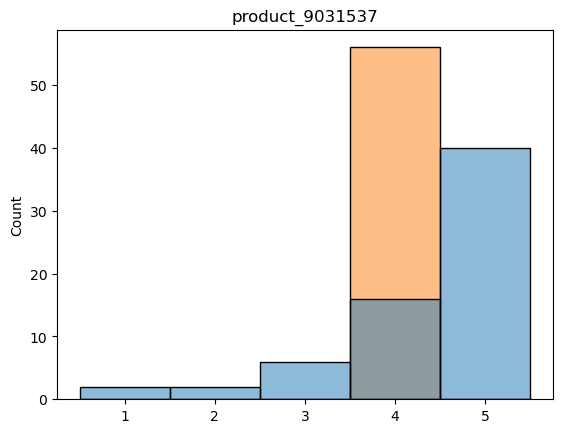

In [147]:
#results = {}
##Choosing 'k_prods' random products to test and looping over them
#for i in random.choices(list(tens_test.keys()), k=k_prods):
#    print('product_'+str(i))
#    
#    #Transforming each product's test set into a dataloader
#    c = SlidingDataset(torch.from_numpy(np.array(tens_test.get(i))), 10)
#    test_product_i = DataLoader(c,len(tens_test.get(i)))
#
#    #feeding the dataloader to the model & predicting
#    for batch, (inputs, targets) in enumerate(test_product_i):
#        inputs[0] = inputs[0].cuda() 
#        inputs[1] = inputs[1].cuda()
#        targets = targets.cuda()
#        model.eval()
#        prediction = model(inputs)
#    
#    # Collecting prediction vs targets, transforming them into histogram format
#    prediction_round=[round(float(e), 0) for e in prediction[0]]
#    real_ratings = [int(a[0]) for a in tens_test.get(i)]
#    
#    
#    real_ratings_hist = []
#    predic_ratings_hist = []
#    
#    for o in range(1,6):
#        real_ratings_hist.append(real_ratings[10:].count(o))
#        predic_ratings_hist.append(prediction_round.count(o))
#        
#    # Adding a tuple with predictions and targets to the results dictionary
#    results['product_' + str(i)] = (real_ratings_hist, predic_ratings_hist)
#    
#    if len(random.choices(list(tens_test.keys()), k=k_prods)) == 1:
#        g = sns.histplot(data=[real_ratings,prediction_round], bins=5, discrete=True, legend=False).set(title=('product_'+str(i)))
#        plt.legend(loc='upper left', labels=['Prediction', 'Real data'])
#        plt.show(g)

### J. OLD-DISCARDED: LSTM model for classifcation

In [ ]:
#class LSTM_0(nn.Module):
#    def __init__(self, input_dim, hidden_dim, layer_dim):
#        super(LSTM_0, self).__init__()
#        
#        self.input_dim = input_dim # n of expected features in the input
#        self.hidden_dim = hidden_dim # Hidden dimensions - n of features in hidden state
#        self.layer_dim = layer_dim  # Number of hidden layers 
#        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim) #LSTM
#        self.output_layer = nn.Linear(10,1)
#        self.double()
#
#    def forward(self, x):
#        # Initialize hidden state & cell states with zeros 
#        # theoretically not 100% necessary - made by default for zeros
#        h0 = torch.zeros(self.layer_dim, 10).requires_grad_()
#        c0 = torch.zeros(self.layer_dim, 10).requires_grad_()
#
#        out, (hn, cn) = self.lstm(x.double(), (h0.double(),c0.double()))
#        out2 = self.output_layer(out)
#        #out, (hn, cn) = self.lstm(x)
#        #final_out = self.readout(out[-1])
# 
#        return out, hn, cn #, final_out